# ML Model training for classifying electrons and jets

In this notebook, we are attempting to use various Machine Learning Models for electron identification at ATLAS.
<br>
These models are trained with data which have undergo simple eFEX cuts. (obtained from "*Simple_Parameter_Cut.ipynb*")
<br>
The trained model are then saved into a file. ("*saved_model_cut_data*")
<br>
The performance will then compared to the current eratio algorithm.

In [1]:
# Importing required packages
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import pickle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from scikeras.wrappers import KerasClassifier
from datetime import datetime
import os, sys
from tensorflow import keras
from keras import callbacks

In [2]:
# setting parameters
import matplotlib as mpl  
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
warnings.filterwarnings('ignore')
xgb.set_config(verbosity=0)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


# set random state to ensure results are reproducible
randomizer = 777

# Importing Data

In [3]:
ele_data = np.loadtxt('cut_ele_data.txt', delimiter = '	')
jet_data = np.loadtxt('cut_jet_data.txt', delimiter = '	')

# Pre-processing data
### Creating data frame for 3x17 cell information

In [4]:
ele_data_cell = []                          # array for electron cell information

for i in range (len(ele_data)):             
    ele_data_cell.append(ele_data[i][12:])
    
jet_data_cell = []                          # array for jet cell information

for i in range (len(jet_data)):
    jet_data_cell.append(jet_data[i][12:])
    
    
ele_data = ele_data_cell
jet_data = jet_data_cell

print("Shape of electron cell array", np.shape(ele_data))
print("Shape of jet cell array", np.shape(jet_data))


Shape of electron cell array (26261, 51)
Shape of jet cell array (6593, 51)


### Normalisation
All ML models are trained with three types of data.
- original data
- normalised data by dividing maximum of cell energy *(mnorm)*
- normalised data by dividing sum of cell energies *(snorm)*

In [5]:
def mnorm(data):
    '''
    Function for normalise image data using maximum cell energy
    
    Input:
    data to be normalised
    Output:
    normalised data
    '''
    normdata=[]
    for i in range (len(data)):
        normdata.append(data[i]/np.max(data[i]))
    return np.asarray(normdata)

In [6]:
def snorm(data):
    '''
    Function for normalising image data using sum of cell energies
    
    Input:
    data = data to be normalised
    Output:
    Normalised data
    '''
    normdata=[]
    for i in range (len(data)):
        normdata.append(data[i]/np.sum(data[i]))
    return np.asarray(normdata)

### Function to convert data into 2D picture

This is required only for *CNN* model which takes in training data as an image.

In [7]:
def convert2D(data):
    '''
    Function to convert data array into 2D picture
    
    Input: 
    data in shape (51,)
    
    Output: 
    data in picture shaped (3,17)
    '''
    array = []
    for i in range (len(data)):
        a = np.reshape(data[i], [3, 17])
        array.append(a)
    return array
        

### Preparing input data

1. A function is written to first label electron and jet data as 1 and 0 respectively.

2. It is then normalised or convert into a 2D array using previous functions.

3. The dataset is then reshape to contain information in the following order **[Number of input data, Shape of input data, 1]** for `CNN` training. (The last array is set to be 1 as a color channel which is required for `keras`)

4. Data is then split into 80% for training, 10% for testing and 10% for validation

In [8]:
def prepare_data(shape, ele_data, jet_data):
    '''
    Function to prepare dataset for ML training accordingly
    
    Input data:
    shape = required shape for input (2 for CNN and 1 for other ML models)
    ele_data = electron data
    jet_data = jet data
    
    Output data:
    Data with different normalisation method which are split into train, test, validation
    '''

    # labelling data with 1 and 0
    x_ele = ele_data
    y_ele = np.ones(len(x_ele))

    x_jet = jet_data
    y_jet = np.zeros(len(x_jet))
    
    # convert data into 2D frame for CNN
    if shape == 2:
        x_ele = convert2D(x_ele)
        x_jet = convert2D(x_jet)
        
    # normalising data
    mnormx_ele = mnorm(x_ele)
    mnormx_jet = mnorm(x_jet)
    
    snormx_ele = snorm(x_ele)
    snormx_jet = snorm(x_jet)
    
    # preparing data set into an array
    x = np.append(x_ele, x_jet, axis = 0)
    y = np.append(y_ele, y_jet, axis = 0)
    
    mnormx = np.append(mnormx_ele, mnormx_jet, axis=0)
    mnormy = np.append(y_ele, y_jet, axis=0)
    
    snormx = np.append(snormx_ele, snormx_jet, axis=0)
    snormy = np.append(y_ele, y_jet, axis=0)
    
    # reshaping of input data as required for CNN
    if shape == 2:
        x = x.reshape( (x.shape[0], x.shape[1], x.shape[2], 1) )
        mnormx = mnormx.reshape( (mnormx.shape[0], mnormx.shape[1], mnormx.shape[2], 1) )
        snormx = snormx.reshape( (snormx.shape[0], snormx.shape[1], snormx.shape[2], 1) )
    

    # Train, test, validation split
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=0.1, 
                                                        shuffle=True, 
                                                        random_state=randomizer)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                      test_size=0.1/(1-0.1), 
                                                      shuffle=True, 
                                                      random_state=randomizer)
    
    mnormx_train, mnormx_test, mnormy_train, mnormy_test = train_test_split(mnormx,mnormy, 
                                                                            test_size=0.1, 
                                                                            shuffle=True, 
                                                                            random_state=randomizer)
    mnormx_train, mnormx_val, mnormy_train, mnormy_val = train_test_split(mnormx_train,mnormy_train, 
                                                                          test_size=0.1/(1-0.1), 
                                                                          shuffle=True, 
                                                                          random_state=randomizer)
    
    snormx_train, snormx_test, snormy_train, snormy_test = train_test_split(snormx,snormy, 
                                                                            test_size=0.1, 
                                                                            shuffle=True, 
                                                                            random_state=randomizer)    
    snormx_train, snormx_val, snormy_train, snormy_val = train_test_split(snormx_train,snormy_train, 
                                                                          test_size=0.1/(1-0.1), 
                                                                          shuffle=True, 
                                                                          random_state=randomizer)
    dataset = [
        [x_train, y_train, x_test, y_test, x_val, y_val],
        [mnormx_train, mnormy_train, mnormx_test, mnormy_test, mnormx_val, mnormy_val],
        [snormx_train, snormy_train, snormx_test, snormy_test, snormx_val, snormy_val],
             ]
    
    return dataset

In [9]:
a = prepare_data(2, ele_data, jet_data)

print("Training data size", len(a[0][0]))
print("Testing data size", len(a[0][2]))
print("Validation data size", len(a[0][4]))


Training data size 26282
Testing data size 3286
Validation data size 3286


# Model Architecture

ML models are prepared with their specific parameters

In [10]:
# CNN Model Architecture
def CNNmodel2layer():
    modelCNN=keras.models.Sequential()
    modelCNN.add(keras.layers.Conv2D(32, (1,3), activation='relu', input_shape=[3,17,1]))  # 1st Conv layer
    modelCNN.add(keras.layers.Conv2D(32, (2,2), activation='relu' ))                       # 2nd Conv layer
    modelCNN.add(keras.layers.MaxPooling2D((2, 2)))                                        # max-pool down-sampling
    modelCNN.add(keras.layers.Dropout(rate = 0.2))                                         # dropout layer

    modelCNN.add(keras.layers.Flatten())                                                   # flatten output
    modelCNN.add(keras.layers.Dense(256))                                                  # dense layer

    modelCNN.add(keras.layers.Activation('relu'))                                          # activation layer
    modelCNN.add(keras.layers.Dropout(rate = 0.2))                                         # dropout layer
    modelCNN.add(keras.layers.Dense(1, activation='sigmoid'))                              # final output
    modelCNN.compile(loss="binary_crossentropy",optimizer='adam', metrics=['accuracy'])    # compiling model 

    return modelCNN

# early stopping set up to avoid overfitting
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", verbose = 1,           
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True);

## Buidling all ML models
List of ML models:
- CNN
- Nearest Neighbour
- Decision Tree
- Random Forest
- XGBoost
- Simple Neural Net
- AdaBoost

In [11]:
model_name = [
              'CNN',
              'NearestNeighbour',
              'DecisionTree',
              'RandomForest',
              'XGBoost',
              'NeuralNet',
              'AdaBoost'
             ]


classifier = [
              # CNN
              CNNmodel2layer(),      
    
              # Nearest Neighbours
              KNeighborsClassifier(n_neighbors=30, n_jobs=-1), 
    
              # Decision Tree
              DecisionTreeClassifier(                          
                criterion='entropy',
                random_state=randomizer,
                max_depth=10,
                min_samples_leaf=1,
                min_samples_split=2,
                splitter='best'
              ),
    
              # Random Forest
              RandomForestClassifier(
                  max_depth=30, 
                  n_estimators=30, 
                  n_jobs=-1, 
                  warm_start=False, 
                  random_state=randomizer
              ),

              # XGBoost
              xgb.XGBClassifier(
                  n_estimators=100,
                 colsample_bytree=0.8317,
                  learning_rate=0.1,
                  max_depth=20,
                  min_child_weight=3.0,
                  subsample=0.9099,
                  gamma=0.292,
                  reg_lambda=0.447,
                  objective='binary:logistic',
                  rate_drop=0.2,
#                   tree_method='gpu_hist',
                  silent=True,
                
              ),
                 
              # Neural Net
              MLPClassifier(
                  max_iter=1000, 
                  shuffle=True, 
                  warm_start=False, 
                  early_stopping=True, 
                  validation_fraction=0.1, 
                  random_state=randomizer,
              ),
    
              # AdaBoost
              AdaBoostClassifier(n_estimators=200, 
                                 learning_rate=0.5, 
                                 random_state=randomizer),

                ]


# 3 types of input data
data_type_name = ['original',
                  'normalised(max)',
                  'normalised(sum)'
                 ]
             

# Model Training

Model is trained using prepared data accordingly.

It is then used to make prediction on test dataset with two metric:
- ROC score
- Rejection value when signal efficiency of electrons is at 90% (fpr when tpr=0.9)



CNN
Restoring model weights from the end of the best epoch: 27.
Epoch 32: early stopping
103/103 [==============================] - 0s 2ms/step
Trained using original data
ROC score = 0.9473001819626579
At 90% signal efficiency we have a false positive rate of 0.1196

Restoring model weights from the end of the best epoch: 21.
Epoch 26: early stopping
103/103 [==============================] - 0s 2ms/step
Trained using normalised(max) data
ROC score = 0.9545933816372878
At 90% signal efficiency we have a false positive rate of 0.1025

Restoring model weights from the end of the best epoch: 21.
Epoch 26: early stopping
103/103 [==============================] - 0s 2ms/step
Trained using normalised(sum) data
ROC score = 0.9525298451671752
At 90% signal efficiency we have a false positive rate of 0.1071


NearestNeighbour
Trained using original data
ROC score = 0.9244863786609993
At 90% signal efficiency we have a false positive rate of 0.1769

Trained using normalised(max) data
ROC score

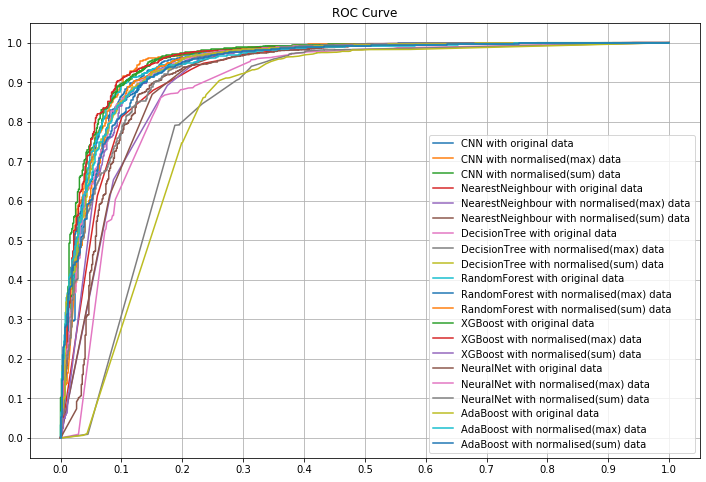

In [13]:
fig, axs = plt.subplots()

for name , model in zip(model_name, classifier):
    print(name)
    
    ##### Data preparation #####

    # Data prepared for CNN model
    if name == 'CNN':
        shape = 2
        val = True
        data_type = prepare_data(shape, ele_data, jet_data)
    
    # Data prepared for XGBoost
    elif name == 'XGBoost':
        shape = 1
        val = True
        data_type = prepare_data(shape, ele_data, jet_data)
    
    # Data prepared for other ML models
    else:
        shape = 1
        val = False
        data_type = prepare_data(shape, ele_data, jet_data)
    
    ##### Model Training ######    
    for data_name, data in zip(data_type_name, data_type):
        filename = 'saved_model_cut_data/' + str(name) + str(data_name) + '.pickle' # path and filename to save trained models
        
        # Training for CNN model
        if val == True and shape == 2:
            
            clf = CNNmodel2layer()
            clf.fit(data[0], data[1], 
                    epochs=40,
                    batch_size=200, 
                    validation_data=(data[4], data[5]), 
                    shuffle = True, 
                    verbose=0, 
                    callbacks=earlystopping)
            
            prob = clf.predict(data[2])                                 # model prediction on test dataset
            
        # Training for XGBoost
        elif val == True and shape == 1:
            clf = model
            eval_set = [(data[4], data[5])]
            clf.fit(data[0], data[1], early_stopping_rounds=5, eval_metric="auc", eval_set=eval_set, verbose=False)
            prob = clf.predict_proba(data[2])[:,1] # model prediction on test dataset
            
        # Training for other ML models    
        else:
            clf = model
            clf.fit(data[0], data[1])
            prob = clf.predict_proba(data[2])[:,1]                      # model prediction on test dataset
        
        pickle.dump(clf, open(filename,'wb'))                           # saving trained models

        ###### Model Testing ######
        roc_auc = roc_auc_score(data[3], prob)                          # ROC score for model
    
        print("Trained using", data_name, "data")
        print("ROC score =", roc_auc)

        fpr, tpr, thresholds = roc_curve(data[3], prob)                 # fpr and tpr value for model
        value = np.interp(0.9, tpr, fpr)                                # obtain fpr for 90% tpr on ROC curve
        print("At 90% signal efficiency we have a false positive rate of {0:.4f}". format(value))
        
        ###### Plot ######
        plt.figure(1)
#         if data_name=='original':
        plt.plot(fpr, tpr, label= name + ' with '+ data_name + ' data')  # ROC curve for each model
        plt.title("ROC Curve")                                           # plot title
        plt.grid(True)                                                   # show grid on plot
        plt.xticks(np.arange(0,1.1,0.1));                                # set x axis ticks
        plt.yticks(np.arange(0,1.1,0.1));                                # set y axis ticks
        plt.legend(loc='best')                                           # show legend
        print()
    print()
plt.show()

# Saving Model

These trained models are saved as .pickle files into a directory named "saved_model_cut_data" for further testing.